In [295]:
import duckdb

conn = duckdb.connect("data/data.db")

query = """
select
    f.video_frame_index,
    f.timestamp_ms,
    d.id,
    r.cluster_id,
    d.osnet_embedding,
    d.clip_embedding,
from reid_cluster r
left join detection d on d.id=r.person_detection_id
left join frame f on f.id=d.frame_id
left join video v on v.id=f.video_id
where
    v.filepath ilike '%video_1%'
    and not r.is_bad_frame
"""

df = conn.sql(query).df()
df.head()

,video_frame_index,timestamp_ms,id,cluster_id,osnet_embedding,clip_embedding
0,0,0.0,4d1565d1-e4df-4062-80e6-439e6060cbc7,0,"[0.0, 0.1531789, 0.0, 0.0, 0.006920417, 0.0123...","[0.059039026, 0.028251389, -0.010285831, 0.006..."
1,1,41.0,7e3016de-5a4a-4527-a516-539f778c99dd,0,"[0.0058682356, 0.15271908, 0.0, 0.0, 0.0, 0.01...","[0.0639408, 0.030339804, -0.011091694, 0.00769..."
2,2,83.0,8966d0de-1273-4080-afbf-18c7f9123a81,0,"[0.021453246, 0.16050723, 0.0, 0.0, 0.00687443...","[0.064323075, 0.023080628, -0.012691065, 0.008..."
3,3,125.0,b64d1ae5-0c96-413b-b70b-406880592270,0,"[0.019822454, 0.15694407, 0.0, 0.0, 0.01747229...","[0.057155635, 0.03902642, -0.005377944, 0.0140..."
4,4,166.0,47ae2586-6949-4c00-8e59-1367f6403dd7,0,"[0.017267754, 0.13731705, 0.0, 0.0, 0.01530893...","[0.06651287, 0.05380341, -0.0077134566, 0.0115..."


[4212]
[215, 465, 675, 1880, 2000, 2130, 2255, 3185, 3370, 3480, 3615, 4212]
0    4212
Name: count, dtype: int64


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

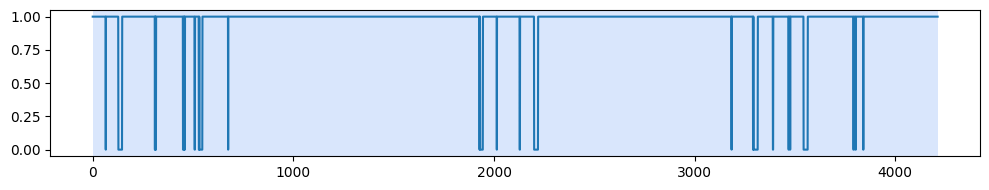

In [306]:
import numpy as np
import ruptures as rpt
import pandas as pd
import plotly.express as px
from scipy.ndimage import binary_opening, binary_closing

max_frame = df['video_frame_index'].max()
min_frame = df['video_frame_index'].min()
n_frames = max_frame + 1

clusters = df['cluster_id'].unique()

cluster_signals = {
    int(cluster_id): np.zeros(n_frames, dtype=np.uint8) for cluster_id in clusters
}

cluster_breakpoints = {}
bucket_labels = {}

for cluster_id, group in df.groupby("cluster_id"):
    cluster_signals[cluster_id][group["video_frame_index"].values] = 1

    signal = cluster_signals[cluster_id]
    
    # smooth flickers in signal signal
    smoothed = binary_closing(signal, structure=np.ones(10))
    smoothed = binary_opening(smoothed, structure=np.ones(10))
    

    algo = rpt.Pelt(model="l2", min_size=100).fit(smoothed)
    breakpoints = algo.predict(pen=20)
    
    min_length = 150
    filtered_cps = [cp for i, cp in enumerate(breakpoints)
                if i == 0 or (cp - breakpoints[i-1]) > min_length]
    cluster_breakpoints[cluster_id] = breakpoints
    print(breakpoints)
    
    labels = np.full_like(signal, fill_value=-1, dtype=np.int8)  # or use None or np.nan if preferred
    bucket = 0
    bp_idx = 0

    prev = 0
    curr = 0
    curr_label = 0
    
    for breakpoint in breakpoints:
        curr = breakpoint
        
        labels[prev:curr] = curr_label
        
        prev = breakpoint
        curr_label += 1
    
    bucket_labels[cluster_id] = labels[labels != -1]

PERSON_ID = 0

print(pd.Series(bucket_labels[PERSON_ID]).value_counts())
rpt.display(cluster_signals[PERSON_ID], cluster_breakpoints[PERSON_ID])

In [300]:
import pandas as pd

person_1 = df[df['cluster_id'] == PERSON_ID]
person_1 = person_1.merge(
    pd.DataFrame({
        "appearance_bucket": bucket_labels[PERSON_ID],
        "signal": cluster_signals[PERSON_ID]
    }),
    how="left",
    left_on="video_frame_index",
    right_index=True
)
# get interarrival times
person_1['iat'] = person_1['timestamp_ms'].diff().fillna(0)

# normalize iat per bucket
person_1['iat_norm'] = person_1.groupby('appearance_bucket')['iat'].transform(
    lambda x: (x + 1e-3) / (x.sum() + 1e-6)
)

person_1 = person_1.groupby('appearance_bucket').filter(lambda g: g['signal'].sum() > 10)

# sample person_1 to prioritize sparser samples
STRATIFIED_SAMPLE_K = 100

person_1 = (
    person_1
    .sort_values('iat_norm', ascending=False)
    .groupby('appearance_bucket')
    .head(STRATIFIED_SAMPLE_K)
    .sort_values('video_frame_index')
)
person_1.head()

,video_frame_index,timestamp_ms,id,cluster_id,osnet_embedding,clip_embedding,appearance_bucket,signal,iat,iat_norm
70,69,2875.0,9d1f9dff-35d3-4d04-9151-4b37787deaab,1,"[0.0, 0.037265375, 0.0, 0.0, 0.057441033, 0.0,...","[0.04354888, 0.0034070686, -0.0021429, 0.00196...",0,1,42.0,0.007050
72,70,2916.0,5e9c5192-84e9-46ea-b23e-13036d7cfc30,1,"[0.0, 0.033935294, 0.0, 0.0, 0.06171632, 0.0, ...","[0.05708453, 0.009688978, 0.0077791982, 0.0105...",0,1,41.0,0.006882
74,71,2958.0,130095a4-d00f-4862-9e61-2600e6c369c7,1,"[0.0, 0.023201726, 0.0, 0.0, 0.050208084, 0.0,...","[0.065099426, -0.0065944847, 0.006024134, 0.01...",0,1,42.0,0.007050
76,72,3000.0,cb7981ed-9117-4ef3-8cd9-e77f8629548a,1,"[0.0, 0.0, 0.0, 0.0, 0.100598186, 0.0, 0.02883...","[0.071949564, 0.00031955692, 0.0065214233, 0.0...",0,1,42.0,0.007050
78,73,3041.0,a3d05223-f995-45e1-882a-3dbf7996d511,1,"[0.0, 0.0, 0.0, 0.0, 0.08992666, 0.01390315, 0...","[0.062284485, -0.008417207, 0.0017762535, 0.00...",0,1,41.0,0.006882


In [301]:
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

# higher energy = more change
# this is like a non-parametric version of KL divergence
# we could also do a gaussian KDE and then measure residuals but this requires no
# model training >:)

def energy_distance_cosine(X: np.ndarray, Y: np.ndarray):
    N, M = len(X), len(Y)
    cross = np.sum(cdist(X, Y, metric="cosine")) / (N * M)
    xx = np.sum(cdist(X, X, metric="cosine")) / (N * N)
    yy = np.sum(cdist(Y, Y, metric='cosine')) / (M * M)
    return 2 * cross - xx - yy

person_1['clip_pca_50'] = PCA(n_components=50).fit_transform(person_1['clip_embedding'].to_list()).tolist()

appearance_buckets = []
appearance_matrices = []
distances = [0]

for appearance_bucket, dff in person_1.groupby('appearance_bucket'):
    appearance_buckets.append(appearance_bucket)
    appearance_matrices.append(np.stack(dff['clip_pca_50'].to_list()))

for i in range(1, len(appearance_buckets)):
    curr = appearance_matrices[i]
    prev = appearance_matrices[i-1]
    distances.append(energy_distance_cosine(curr, prev))

print([i.size for i in appearance_matrices])
print(len(appearance_buckets), len(distances))
print([float(round(i, 3)) for i in distances])

[5000, 5000, 4500, 4950, 5000, 5000]
6 6
[0.0, 0.252, 0.696, 0.239, 0.61, 0.403]


/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:340: RuntimeWarning:

divide by zero encountered in matmul


In [305]:
THRESHOLD = 0.48

anomalies = {b: bool(distance > THRESHOLD) for b, distance in zip(appearance_buckets, distances)}
person_1['is_anomaly'] = person_1['appearance_bucket'].map(anomalies)
print(anomalies)
person_1.head()

{0: False, 2: False, 4: True, 6: False, 8: True, 10: False}


,video_frame_index,timestamp_ms,id,cluster_id,osnet_embedding,clip_embedding,appearance_bucket,signal,iat,iat_norm,clip_pca_50,is_anomaly
70,69,2875.0,9d1f9dff-35d3-4d04-9151-4b37787deaab,1,"[0.0, 0.037265375, 0.0, 0.0, 0.057441033, 0.0,...","[0.04354888, 0.0034070686, -0.0021429, 0.00196...",0,1,42.0,0.007050,"[-0.12906771214929944, -0.1453148948562715, 0....",False
72,70,2916.0,5e9c5192-84e9-46ea-b23e-13036d7cfc30,1,"[0.0, 0.033935294, 0.0, 0.0, 0.06171632, 0.0, ...","[0.05708453, 0.009688978, 0.0077791982, 0.0105...",0,1,41.0,0.006882,"[-0.055086798678680986, -0.17498281203011298, ...",False
74,71,2958.0,130095a4-d00f-4862-9e61-2600e6c369c7,1,"[0.0, 0.023201726, 0.0, 0.0, 0.050208084, 0.0,...","[0.065099426, -0.0065944847, 0.006024134, 0.01...",0,1,42.0,0.007050,"[-0.03909538650639706, -0.1890384317292074, -0...",False
76,72,3000.0,cb7981ed-9117-4ef3-8cd9-e77f8629548a,1,"[0.0, 0.0, 0.0, 0.0, 0.100598186, 0.0, 0.02883...","[0.071949564, 0.00031955692, 0.0065214233, 0.0...",0,1,42.0,0.007050,"[-0.07526160110638112, -0.20108032972249937, 0...",False
78,73,3041.0,a3d05223-f995-45e1-882a-3dbf7996d511,1,"[0.0, 0.0, 0.0, 0.0, 0.08992666, 0.01390315, 0...","[0.062284485, -0.008417207, 0.0017762535, 0.00...",0,1,41.0,0.006882,"[-0.09559551870282061, -0.17064217545046, -0.0...",False
